To analyse a model we still need to access the data whihc is here presented. The data needs to be divided so there are batches for testing and the encoder so the code can have an output of a word an not a number at the end.

In [ ]:
from google.colab import drive
import zipfile
import os
from os import listdir, path
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline
from matplotlib import pyplot
from sklearn import preprocessing
import keras
from keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense, Reshape
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
ROOT_DIR = '/tmp/valid'
image_size = (64,64)    #tamanho das imagens do resnet
images = []
labels = []

In [ ]:
drive.mount('/content/drive')
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/valid.zip', 'r') #no folder do notebook procurar o folder onde está o zip e copiar o caminho
zip_ref.extractall('/tmp')
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
all_paths = []
all_labels = []
all_species = []
all_labels_tog =[]
all_paths_tog = []
labels_for_enc = []
plant_folders = listdir(ROOT_DIR)
delete = ["blueberry", "orange", "raspberry", "soybean", "squash"]


for folder in plant_folders:
    plant_list_path = listdir(path.join(ROOT_DIR,folder))
    img_paths = []
    labels = []
    species = []

    for img_dir in plant_list_path:
      specie = (img_dir.split(' ')[0]).lower()         #specie of that image; 'tomato', 'blueberry', etc 
      if specie not in delete:

        label = img_dir.split(' ')[1].lower()          #label of that image; 'black_rot', 'late_blight', 'healthy', etc   
        img_path = path.join(ROOT_DIR, folder, img_dir)
        img_paths.append(img_path)             #list of paths for all images of that folder; list will later be used for all_paths; [path_image1, path_image2, path_image3, path_image4]
        labels.append(label.lower())           #list of labels for all images of that folder; list will later be used for all_labels; [label1, label1, label1, label1, label1]
        species.append(specie)

    if label == "healthy":

      dividir = int(len(labels)/10)
      labels_for_enc.append(label.lower()[0:dividir])     #list of all labels that will later be used to create an encoder
      all_paths.append(img_paths[0:dividir])              #list of lists with the paths of each image; each list has a collection of the paths of all images for one of the 38 folders; 38 lists inside one list; each list inside has different lengths; [[path_image1_label1, path_image2_label1, path_image3_label1], [path_image1_label2, path_image2_label2, path_image3_label2], [path_image1_label3, path_image2_label3, path_image3_label3]]
      all_labels.append(labels[0:dividir])                #list of lists with the labels of each image; each list has a collection of the labels of all images for one of the 38 folders; 38 lists inside one list; each list inside has different lengths; [[label1_image1, label1_image2, label1_image3], [label2_image1, label2_image2, label2_image3], [label3_image1, label3_image2, label3_image3]]
      all_species += species[0:dividir]
      all_labels_tog += labels[0:dividir]
      all_paths_tog += img_paths[0:dividir]


    else:

      labels_for_enc.append(label.lower())     #list of all labels that will later be used to create an encoder
      all_paths.append(img_paths)              #list of lists with the paths of each image; each list has a collection of the paths of all images for one of the 38 folders; 38 lists inside one list; each list inside has different lengths; [[path_image1_label1, path_image2_label1, path_image3_label1], [path_image1_label2, path_image2_label2, path_image3_label2], [path_image1_label3, path_image2_label3, path_image3_label3]]
      all_labels.append(labels)                #list of lists with the labels of each image; each list has a collection of the labels of all images for one of the 38 folders; 38 lists inside one list; each list inside has different lengths; [[label1_image1, label1_image2, label1_image3], [label2_image1, label2_image2, label2_image3], [label3_image1, label3_image2, label3_image3]]
      all_species += species
      all_labels_tog += labels
      all_paths_tog += img_paths     


In [ ]:
labels_for_enc = np.unique(labels_for_enc)

In [ ]:
labels_for_enc = list(filter(None, labels_for_enc))
encode = {}

for i, label in enumerate(labels_for_enc):
  encode[label] =  i

encode

{'bacterial_spot': 0,
 'black_measles': 1,
 'black_rot': 2,
 'cedar_rust': 3,
 'common_rust': 4,
 'early_blight': 5,
 'gray_leaf_spot': 6,
 'healthy': 7,
 'isariopsis_leaf_spot': 8,
 'late_blight': 9,
 'leaf_mold': 10,
 'leaf_scorch': 11,
 'mosaic_virus': 12,
 'northern_leaf_blight': 13,
 'powdery_mildew': 14,
 'scab': 15,
 'septoria_leaf_spot': 16,
 'target_spot': 17,
 'two_spotted_spider_mite': 18,
 'yellow_leaf_curl_virus': 19}

In [ ]:
num_batchs = 10
bts_paths = {}
bts_labels = {}

for i in range(1,num_batchs+1):
  word = f"batch_{i}"
  bts_paths[word] = []
  bts_labels[word] = []

print(bts_paths)
print(bts_labels)

{'batch_1': [], 'batch_2': [], 'batch_3': [], 'batch_4': [], 'batch_5': [], 'batch_6': [], 'batch_7': [], 'batch_8': [], 'batch_9': [], 'batch_10': []}
{'batch_1': [], 'batch_2': [], 'batch_3': [], 'batch_4': [], 'batch_5': [], 'batch_6': [], 'batch_7': [], 'batch_8': [], 'batch_9': [], 'batch_10': []}


In [ ]:
i = 0
for list_paths in all_paths:
  divided_list = [list(array) for array in np.array_split(np.array(list_paths), num_batchs)]
  for part in divided_list:
    bts_paths[list(bts_paths.keys())[i]] += part
    i+=1
  i=0

In [ ]:
i = 0
for label in all_labels:
  divided_list = [list(array) for array in np.array_split(np.array(label), num_batchs)]
  for part in divided_list:
    encoded_part = []
    for individual_label in part:
      encoded_label = encode[individual_label]
      encoded_part.append(encoded_label)
    bts_labels[list(bts_labels.keys())[i]] += encoded_part
    i+=1
  i=0

Here the best model was loaded and tested.

In [ ]:
model = keras.models.load_model('/content/model (5).h5')

In [ ]:
paths_test = bts_paths['batch_10'] + bts_paths['batch_9']
y_test = bts_labels['batch_10'] + bts_labels['batch_9']
images = []

for path in paths_test:
  image = cv2.imread(path)
  image = cv2.resize(image, image_size)
  images.append(image)

x_test = np.asarray(images, dtype=np.float32)
y_test = np.asarray(y_test, dtype=int)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

71/71 [==============================] - 80s 1s/step


In [ ]:
conf_mat = confusion_matrix(y_test, y_pred, normalize='all')

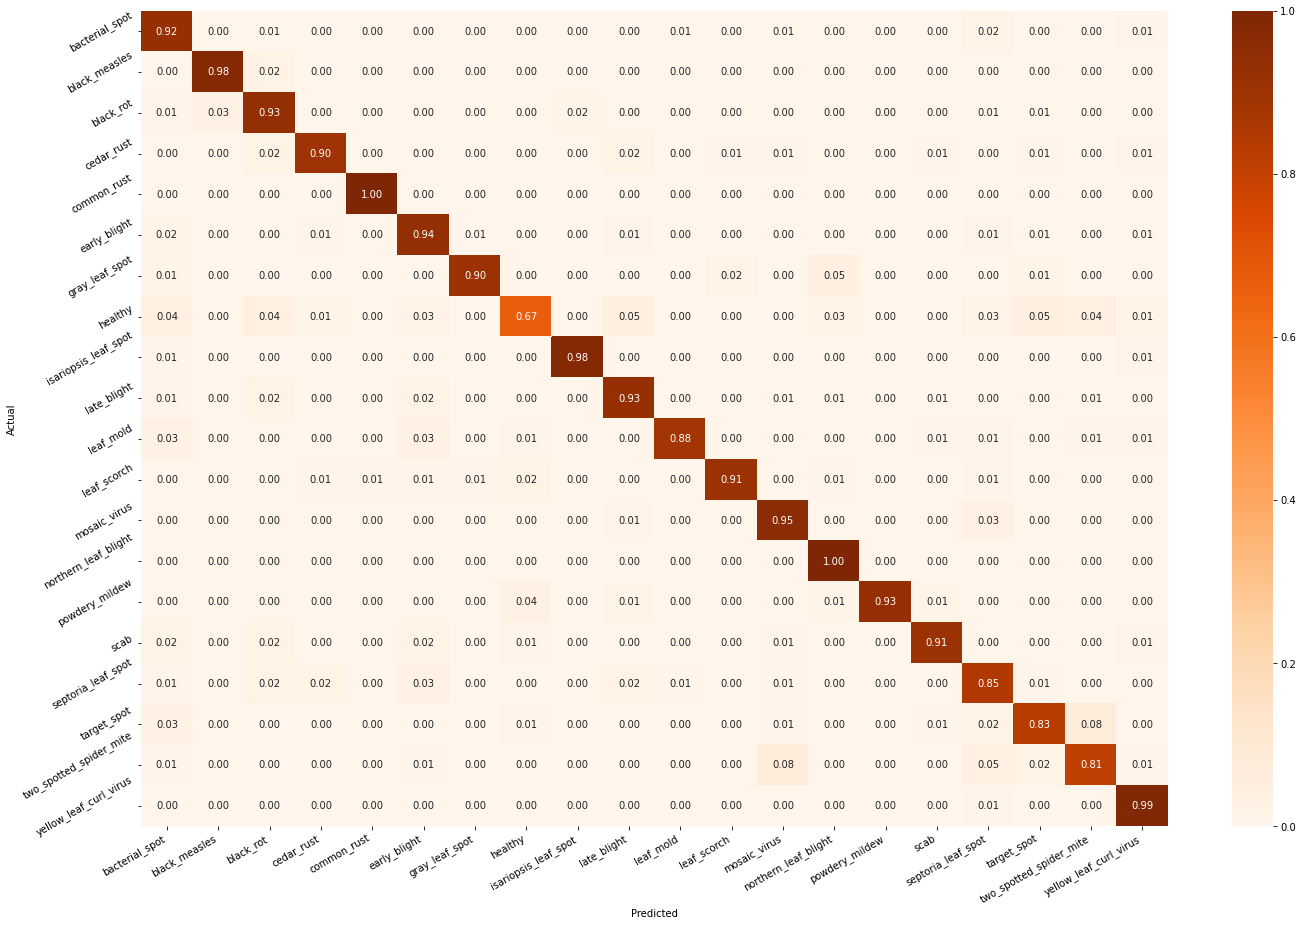

In [ ]:
import matplotlib.pyplot as plt

cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(23,15))
sns.heatmap(cmn, annot=True, fmt='.2f',  cmap="Oranges")
sns.set(font_scale=1.4) # for label size
ax.xaxis.set_ticklabels(labels_for_enc)
ax.yaxis.set_ticklabels(labels_for_enc)
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.setp(ax.get_yticklabels(), rotation=30, ha='right')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
model.evaluate(x_test,y_test)

71/71 [==============================] - 80s 1s/step - loss: 0.4789 - accuracy: 0.9167


[0.4788506329059601, 0.9167400598526001]

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

71/71 [==============================] - 82s 1s/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       269
           1       0.94      0.98      0.96        96
           2       0.91      0.93      0.92       192
           3       0.92      0.90      0.91        88
           4       0.99      1.00      0.99        94
           5       0.91      0.94      0.93       192
           6       0.96      0.90      0.93        82
           7       0.85      0.67      0.75        75
           8       0.97      0.98      0.97        86
           9       0.93      0.93      0.93       188
          10       0.97      0.88      0.92        94
          11       0.95      0.91      0.93        88
          12       0.86      0.95      0.90        88
          13       0.91      1.00      0.95        94
          14       1.00      0.93      0.96        84
          15       0.95      0.91      0.93       100
          16       0.77     

In [ ]:
img =  cv2.imread('/content/TomatoEarlyBlight4.JPG')
img_resized = cv2.resize(img, image_size) 
img_array = img_resized[np.newaxis,:]
prediction = np.argmax(model.predict(img_array), axis=1)

1/1 [==============================] - 0s 140ms/step


Model prediction for the image is:  early_blight


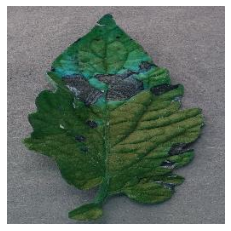

In [ ]:
for key in encode:
  if encode[key] == prediction:
    result = key

print("Model prediction for the image is: ", result)

pyplot.imshow(img)
pyplot.axis("off")
pyplot.show()